### NLP Approach to Modeling Online Reviews
#### Using Automotive Reviews from Amazon and the concept of Topic Modeing (LDA)
Dataset for amazon automotive reviews [here](http://jmcauley.ucsd.edu/data/amazon/)<br>
Insipration from [here](https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/)
Topic modeling is a process to automatically identify topics present in a text object & derive hidden patterns exhibitd by a text corpus.  Useful for:
* Document clustering
* Organizing large blocks of textual data
* Info retrieval from unstructured text
* Feature selection

The goal here is to extract groups of important words from reviews which would help to determine what the customers are talking about in the reviews.

More on topic modeling [here](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)
LDA - Latent Dirichlet Allocation


Topic modeling identifies topics present in a text object and one can use it to derive hidden patterns.  Useful for:
* Document clustering 
* Organizing large blocks of textual data
* Info retrieval from unstructured text
* Feature selection

In this notebook, we are extracting groups of important words from reviews.  This will help determine what the consumers are talking about in the reviews.

In [1]:
#import libraries
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tehila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

import os

#visualtion libraries
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#set directory paths
root_dir = os.path.abspath('../..')
data_dir = os.path.join(root_dir, 'misc_datasets')

os.path.exists(root_dir)
os.path.exists(data_dir)

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [4]:
datafile = os.path.join(data_dir,'reviews_Automotive_5.json')
df = pd.read_json(datafile, lines=True)
df.head()

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]","Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...",5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]","I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...",5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]","I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...",5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


The data contains the following columns:

* `reviewerID` – ID of the reviewer
* `asin` – ID of the product
* `reviewerName` – name of the reviewer
* `helpful` – helpfulness rating of the review, e.g. 2/3
* `reviewText` – text of the review
* `overall` – rating of the product
* `summary` – summary of the review
* `unixReviewTime` – time of the review (unix time)
* `reviewTime` – time of the review (raw)

For this analysis we are only using `reviewText`


#### Data Preprocessing
First we will plot a bar graph of n most frequent words.  Then we will remove punctuation, stopwords, and normalize as much as possible.

In [5]:
# %load freq_words.py
# function to plot most freq terms
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    # select top 20 most freq words
    d = words_df.nlargest(columns='count', n=terms)
    plt.figure(figsize=(20, 5))
    ax = sns.barplot(data=d, x='word', y='count')
    ax.set(ylabel='Count')
    plt.show()

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


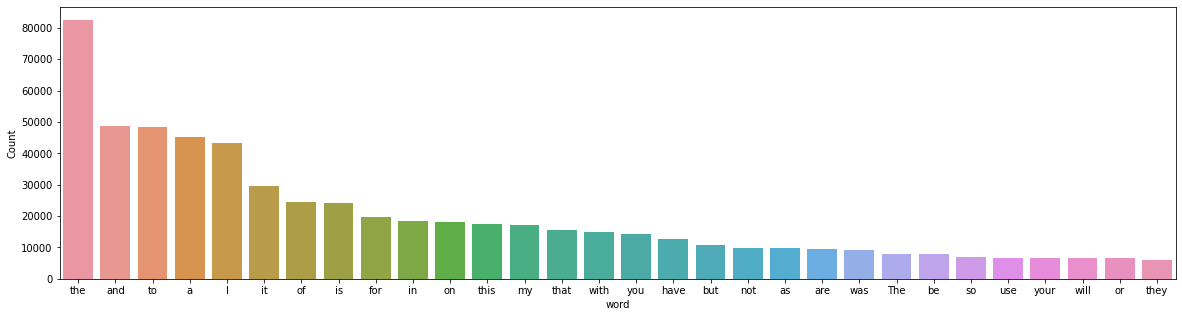

In [6]:
freq_words(df['reviewText'])

Most common words are 'the', 'and', 'to.  We will perform some basic preprocessing and replot the reviews.

In [15]:
# %load basic_preprocess
#basic data cleaning preprocessing
#
#can comment out functions not using after loading

#import libraries for function
from textblob import TextBlob, Word

def basic_preprocess(df,feature):
    #remove URLs
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)
    df[feature] = df[feature].apply(lambda x: remove_URL(x))

    #remove HTML tags
    def remove_html(text):
        html = re.compile(r'<.*?>')
        return html.sub(r'',text)
    df[feature] = df[feature].apply(lambda x: remove_html(x))

#     #remove Emojis
#     def remove_emoji(text):
#         emoji_pattern = re.compile("["
#                                    u"\U0001F600-\U0001F64F"  # emoticons
#                                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                    u"\U00002702-\U000027B0"
#                                    u"\U000024C2-\U0001F251"
#                                    "]+", flags=re.UNICODE)
#         return emoji_pattern.sub(r'', text)
#     df[feature] = df[feature].apply(lambda x: remove_emoji(x))

    #transform to lower case
    df[feature] = df[feature].apply(lambda x: ' '.join(x.lower() for x in x.split()))

#     #remove characters, symbols
#     df[feature] = df[feature].str.replace(r"[^a-zA-Z0-9]"," ")

    # remove characters, symbols,and numbers
    df[feature] = df[feature].str.replace(r"[^a-zA-Z#]", " ")

    #remove stop words
    stop = stopwords.words('english')
    df[feature] = df[feature].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

    #remove 10 most frequently occuring words
    freq = pd.Series(' '.join(df[feature]).split()).value_counts()[:10]
    print('Most commonly used words','\n', freq)
    freq = list(freq.index)
    df[feature] = df[feature].apply(lambda x: ' '.join(x for x in x.split() if x not in freq))

#     #remove rare words
#     freq = pd.Series(' '.join(df[feature]).split()).value_counts()[-10:]
#     print('Rare words', '\n', freq)
#     freq = list(freq.index)
#     df[feature] = df[feature].apply(lambda x: ' '.join(x for x in x.split() if x not in freq))

    # remove short words (length < 3)
    df[feature] = df[feature].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

    #skip spelling corrections for now
    #can use TextBlob to tokenize

#     #will use Lemmatization instead of Stemming
#     df[feature] = df[feature].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

    # function to lemmatize and filter by noun and adjective
    nlp = spacy.load('en', disable=['parser', 'ner'])


    #df[feature] = df[feature].apply(lambda x: )

    return df
def lemmatization(texts, tags=['NOUN', 'ADJ']):  # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output


/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
df_clean = basic_preprocess(df,'reviewText')
df_clean.head()

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Most commonly used words 
 get        4790
time       3965
easy       3778
works      3619
work       3491
much       3437
battery    3269
also       3152
really     3075
using      3007
dtype: int64


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",needed set jumper cables new reviews price times already supposed complaints say feet ideal length sure pull front bumper front bumper plenty long lot times beside another close recommend somethin...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]",long cables fine truck quality seems little shabby side money expecting dollar snap jumper cables seem see chinese knock shop harbor freight bucks,4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",comment since yet come back update review find issues first built solid nice tough big hard clamps love long cable never move cars around anything needed bought new truck since always need cables ...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",absolutley love amazon price set cheap booster jumper cables brick morter store buy extra long heavy duty jumpers first person needs ask kind passer jump jumper cables easier jump start cables nex...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",purchased feet long cable set arrived retail cardboard box handle could storage carrying case cables although need store carry box high quality long cables high grade materials believe worth price...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


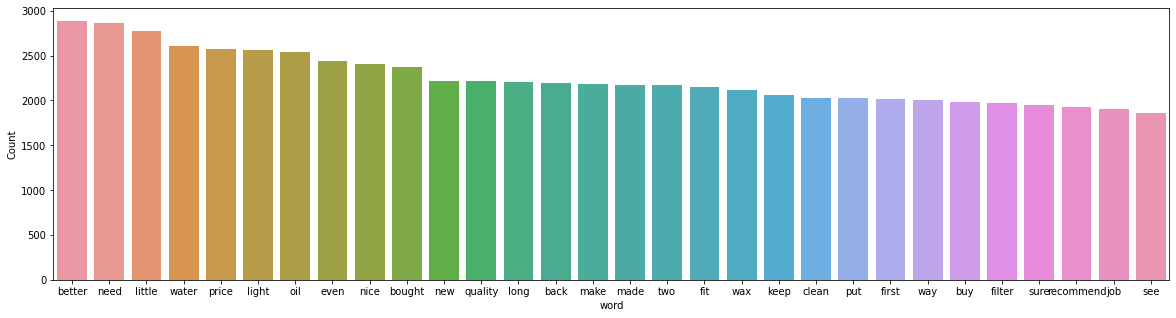

In [17]:
#plot the freq_words again
freq_words(df_clean['reviewText'])

In [18]:
tok_rev = pd.Series(df_clean['reviewText']).apply(lambda x: x.split())
print(tok_rev[1])

['long', 'cables', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'see', 'chinese', 'knock', 'shop', 'harbor', 'freight', 'bucks']


/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# #function to lemmatize and filter by noun and adjective
# nlp = spacy.load('en', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
#        output = []
#        for sent in texts:
#              doc = nlp(" ".join(sent)) 
#              output.append([token.lemma_ for token in doc if token.pos_ in tags])
#        return output

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tokenize the reviews and then lemmatize the tokenized reviews

In [21]:
rev2=lemmatization(tok_rev)
lemmatization
print(rev2[1])

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['long', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cable', 'chinese', 'shop', 'freight', 'buck']


#### Build an LDA model
Create the term dictionary of out corpus.  Every unique term is assigned an index. <br>
Convert list of reviews into a document term matrix using the dictionary.

In [23]:
dictionary = corpora.Dictionary(rev2)

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
doc_term_mat= [dictionary.doc2bow(rev) for rev in rev2]

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
#Create object for LDA model
LDA = gensim.models.ldamodel.LdaModel

#Build LDA model
lda_model = LDA(corpus = doc_term_mat, id2word=dictionary, num_topics=7, random_state=100, chunksize=1000, passes=50)

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
lda_model.print_topics()

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.040*"towel" + 0.033*"wiper" + 0.032*"blade" + 0.025*"water" + 0.013*"windshield" + 0.012*"rain" + 0.011*"dry" + 0.011*"window" + 0.011*"glass" + 0.010*"size"'),
 (1,
  '0.064*"light" + 0.030*"price" + 0.024*"bulb" + 0.020*"bright" + 0.019*"quality" + 0.013*"cheap" + 0.010*"high" + 0.010*"color" + 0.010*"worth" + 0.010*"well"'),
 (2,
  '0.031*"clean" + 0.016*"paint" + 0.015*"product" + 0.015*"filter" + 0.014*"spray" + 0.012*"job" + 0.012*"stuff" + 0.012*"water" + 0.011*"wash" + 0.009*"dirt"'),
 (3,
  '0.036*"leather" + 0.035*"oil" + 0.023*"engine" + 0.016*"seat" + 0.015*"code" + 0.014*"change" + 0.010*"gas" + 0.010*"mile" + 0.010*"bike" + 0.009*"fuel"'),
 (4,
  '0.023*"tire" + 0.016*"hose" + 0.012*"tool" + 0.012*"pressure" + 0.011*"trailer" + 0.010*"gauge" + 0.009*"trip" + 0.008*"air" + 0.008*"bag" + 0.008*"fit"'),
 (5,
  '0.021*"plastic" + 0.012*"pad" + 0.012*"tape" + 0.011*"door" + 0.010*"little" + 0.010*"small" + 0.010*"place" + 0.009*"side" + 0.009*"area" + 0.009*"cover"')

Use the pyLDAvis library to visualize.  This is interactive and displays topics and most relevant words.

In [28]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model, doc_term_mat, dictionary)
vis

/Users/tehila/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.137599 -0.072878       1        1  18.645710
2     -0.021960  0.227137       2        1  17.001207
6     -0.050346 -0.210672       3        1  14.680662
5      0.259416 -0.043275       4        1  13.819852
1     -0.062008  0.019750       5        1  13.260401
0      0.003645  0.141305       6        1  11.790368
3     -0.266345 -0.061368       7        1  10.801801, topic_info=         Term         Freq        Total Category  logprob  loglift
134     light  4764.000000  4764.000000  Default  30.0000  30.0000
486     towel  2090.000000  2090.000000  Default  29.0000  29.0000
1219  leather  1721.000000  1721.000000  Default  28.0000  28.0000
150       oil  1664.000000  1664.000000  Default  27.0000  27.0000
849     wiper  1729.000000  1729.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
176    system   250.341632   744.730747   Topic7  -5.2420   1.1353
174     stuff   252.703248  1146.738158   Topic7  -5.2326   0.7130
241      year   291.185046  2259.173399   Topic7  -5.0908   0.1767
231       old   273.722307  1684.789703   Topic7  -5.1527   0.4082
463       air   230.997753   968.996301   Topic7  -5.3224   0.7916

[405 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1185      6  0.994852     absorbent
1504      7  0.997823  acceleration
1431      1  0.996023     accessory
3147      5  0.989306      accident
1055      1  0.998100      accurate
...     ...       ...           ...
241       3  0.090299          year
241       5  0.218221          year
241       6  0.198303          year
241       7  0.128808          year
5576      6  0.994591         zwipe

[671 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 6, 2, 1, 4])

#### Next steps
* set up for sentiment analysis
* create some word clouds
* create model
* predict


### More Data Explorations

In [48]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Data Cleaning and Preprocessing for Sentiment Analysis
* Combine text columns `reviewText` and `summary` into `reviews`
* Delete columns not using `reviewerID`, `reviewerName`, `helpful`, `unixReviewTime`, `reviewTime`
* Change name `overall` to `ratings`


In [60]:
#import libraries
pd.set_option("display.max_colwidth", 50)


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
datafile = os.path.join(data_dir,'reviews_Automotive_5.json')
data = pd.read_json(datafile, lines=True)
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]","Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...",5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]","I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...",5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]","I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...",5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


In [53]:
data['reviews'] = data['reviewText']+' '+data['summary']
data.rename(columns={'overall':'ratings'},inplace=True)
data.drop(columns=['reviewText','summary','reviewerID','reviewerName','helpful','unixReviewTime','reviewTime'],axis=1,inplace=True)
data.head()

,asin,ratings,reviews
0,B00002243X,5,I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....
1,B00002243X,4,"These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo..."
2,B00002243X,5,"Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ..."
3,B00002243X,5,"I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ..."
4,B00002243X,5,"I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto..."


In [49]:
data.reviews.isnull().sum()

0

In [54]:
print('Total ratings per rating:','\n',data.ratings.value_counts())

#Number of unique ids
print('Number of unique products:',len(data.asin.unique()))
print('Number of rows:',data.shape[0]) 

Total ratings per rating: 
 5    13928
4     3967
3     1430
2      606
1      542
Name: ratings, dtype: int64
Number of unique products: 1835
Number of rows: 20473


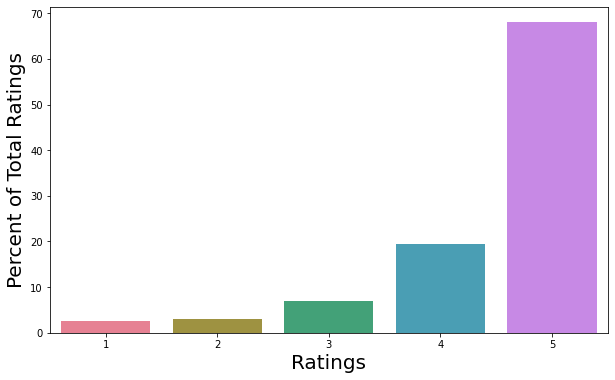

In [58]:
#Plot ratings percentages
ratings_pct=pd.DataFrame(data=data['ratings'].value_counts(normalize=True)*100)
plt.figure(figsize=(10,6))
sns.barplot(x=ratings_pct.index, y=ratings_pct.ratings,palette="husl")
plt.xlabel('Ratings',fontsize=20)
plt.ylabel('Percent of Total Ratings',fontsize=20)
plt.show()

There are very few negative ratings.  Most of the reviews have 5 star ratings.

In [61]:
#Create sentiment column 

data['sentiment'] = data['ratings'].map({5:2,4:2,3:1,2:0,1:0})   
data.head()

,asin,ratings,reviews,sentiment
0,B00002243X,5,I needed a set of jumper cables for my new car...,2
1,B00002243X,4,"These long cables work fine for my truck, but ...",2
2,B00002243X,5,Can't comment much on these since they have no...,2
3,B00002243X,5,I absolutley love Amazon!!! For the price of ...,2
4,B00002243X,5,I purchased the 12' feet long cable set and th...,2


In [62]:
data.sentiment.value_counts(normalize=True)*100

2    87.407805
1     6.984809
0     5.607385
Name: sentiment, dtype: float64

Just over 87% of the ratings are positive.

In [67]:
sizes_rating

[5    0.680311
 4    0.193767
 3    0.069848
 2    0.029600
 1    0.026474
 Name: ratings, dtype: float64]

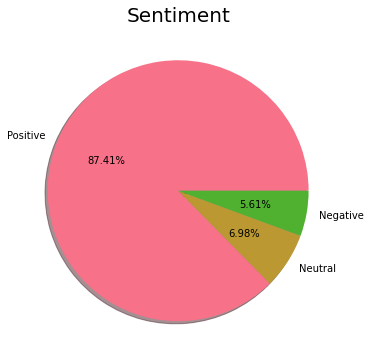

In [93]:
plt.figure(figsize=(10,6))
colors=sns.color_palette("husl")
 
plt.pie(data['sentiment'].value_counts(),colors=colors,labels=['Positive','Neutral','Negative'],autopct='%1.2f%%',shadow=True)
plt.title('Sentiment',fontsize=20)

plt.show()

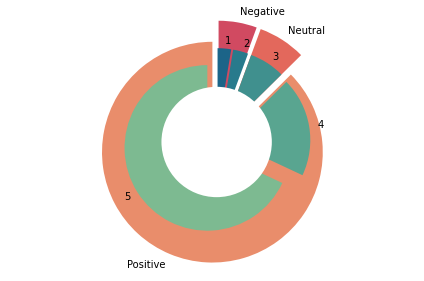

In [89]:
# Data to plot
labels=['Positive','Neutral','Negative']
sizes = data['sentiment'].value_counts()
labels_rating = ['5','4','3','2','1']
sizes_rating = data['ratings'].value_counts()

colors_rating=sns.color_palette("crest")
colors=sns.color_palette("flare")
explode = (0.1,0.1,0.1) 
explode_ratings = (0.1,0.1,0.1,0.1,0.1)

# Plot
plt.pie(sizes, labels=labels, colors=colors, startangle=90,frame=True,explode=explode)
plt.pie(sizes_rating,labels=labels_rating,colors=colors_rating,radius=0.75,startangle=90,explode=explode_ratings)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

* reprocess df with data preprocess function defined above
* create string of positive, negative, neutral for word cloud
* split into train and test
* create models